In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

import matplotlib.cm as cm
from matplotlib.colors import LogNorm

Evaluating round 0 (../build/repeated_fake_3d/stats_0.bag)...
Evaluating round 1 (../build/repeated_fake_3d/stats_1.bag)...
Evaluating round 2 (../build/repeated_fake_3d/stats_2.bag)...
Evaluating round 3 (../build/repeated_fake_3d/stats_3.bag)...
Evaluating round 4 (../build/repeated_fake_3d/stats_4.bag)...
Evaluating round 5 (../build/repeated_fake_3d/stats_5.bag)...
Evaluating round 6 (../build/repeated_fake_3d/stats_6.bag)...
Evaluating round 7 (../build/repeated_fake_3d/stats_7.bag)...
Evaluating round 8 (../build/repeated_fake_3d/stats_8.bag)...
Evaluating round 9 (../build/repeated_fake_3d/stats_9.bag)...


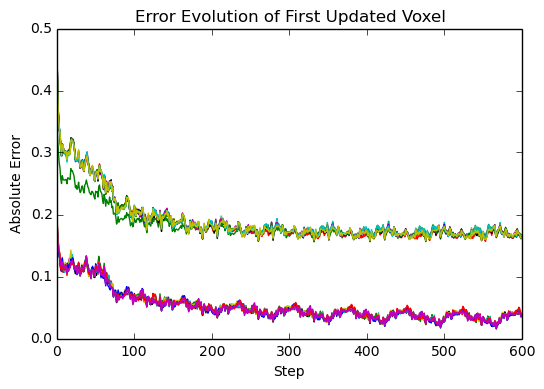

In [17]:
%matplotlib inline
for rnd, filename in enumerate(sorted(glob.glob("../build/repeated_fake_3d/*.bag"), key=lambda f: int(re.findall('([0-9]+)', f[len("../build/repeated_fake_3d/"):])[0]))):
    print "Evaluating round %i (%s)..." % (rnd, filename)
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
        
    start = 0
    err0sBelief = []
    err0sLogOdds = []
    ax = plt.subplot(111)
    for step in range(stats.step):
        err0Belief = np.mean(np.array(stats.errorCompleteUpdatedBelief[start:start + stats.updatedVoxels[step]]))
        err0sBelief.append(err0Belief)
        err0LogOdds = np.mean(np.array(stats.errorCompleteUpdatedLogOdds[start:start + stats.updatedVoxels[step]]))
        err0sLogOdds.append(err0LogOdds)
        start += stats.updatedVoxels[step]
    ax.plot(err0sBelief, label="SMAP")
    ax.plot(err0sLogOdds, label="LogOdds")
    plt.title("Error Evolution of First Updated Voxel")
    ax.set_xlabel("Step")
    ax.set_ylabel("Absolute Error")